## Chi2_Optimization
This notebook plots the trends of the chi2 for a comparison between the simulated pulse and the template as each parameter is varied one at a time. It also plots the results of the best parameter combination.

- We chose to optimize on the $\chi^2$, but stick to large time regions since it's easy to get stuck in a local minimum. Said differently: We will pick CrystalSim parameter values that optimize the fit to the tail (t > 500 $\mu$s). Notes on the optimization method below.
  - Start with the previously picked values.
  - Find the $\chi^2$ as we vary each parameter one at a time and choosing the value that minimizes their 1D $\chi^2$ scans until a minimum was achieved.
  - This new value is used and we do the same for the next parameter.
  - We keep iterating until no parameter changes value.
  - We show we are done by showing the 1D $\chi^2$ variation as we vary each around the final optimized value.
- After that, we use the selected CrystalSim parameters and consider the full time region and find the set of 5 TESSim parameters that minimize the $\chi^2$.
- As a check, we confirm that  the chosen CrystalSim parameters still minimize the $\chi^2$ for the full time region.

In [1]:
import matplotlib.pyplot as plt
%pylab inline
import matplotlib
%matplotlib inline
import pandas as pd
from pylab import *
import matplotlib.patches as mpatches
import numpy
import ROOT 
import root_numpy
from ROOT import TH1D, TFile
import glob
import seaborn as sns

from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
import joblib

Populating the interactive namespace from numpy and matplotlib
Welcome to JupyROOT 6.24/06


In [2]:
# define file paths to the template file, PSDfile, and DMCfile
Templatefile = 'samples/Z14_Templates_R134.root'
rootfile = TFile(Templatefile)
roothist = rootfile.Get('zip14_cdmsliteI/PTslow')
template = root_numpy.hist2array(roothist, return_edges = True)[0]

In [3]:
PSDfile = '/scratch/group/mitchcomp/CDMS/data/catalog-V1.5/psd/LibSimProdv5-4_Filter_01140301_0038.root'
rootfile = TFile.Open(PSDfile)
roothist = rootfile.Get('zip14/PTNoiseFFTsq')
PSD = root_numpy.hist2array(roothist, return_edges = True)[0]

In [4]:
# time bins for TESSim traces
phononBins = np.arange(-819200.0, -819200.0 + 1600 * 4096, 1600) * 1e-3 # ns -> us

In [5]:
# obtain and show the source macro given the root file path
def getMacro(DMCfile):
    f=TFile.Open(DMCfile)
    macro=f.Get("G4SettingsInfoDir/SuperSim_Macro")
    macro.Print()

In [6]:
# obtain and show the software versions given the root file path
def getVersions(DMCfile):
    data = root_numpy.root2array(DMCfile, treename="G4SettingsInfoDir/Versions")
    df = pd.DataFrame(data)
    print(df)

In [7]:
def getCrystalsim(DMCfile, branches):
    #### Retrieve CrystalSim Data, Used to get PhononE values for this study ####
    branches_dic = {}
    for br in branches:
        branches_dic.update({br: []})
        
    data = root_numpy.root2array(DMCfile, treename="G4SimDir/g4dmcEvent", branches = branches)
    for event in range(len(data)):
        for br in branches:
            branches_dic[br].append(data[br][event])
            
    for br in branches:
        branches_dic[br] = np.array(branches_dic[br])
    
    return tuple(branches_dic.values())

In [8]:
def getTES(file):
    tesa, tesb, tesc, tesd = [], [], [], []
    #### Retrieving the TES traces for each channel ####
    data = root_numpy.root2array(file, treename="G4SimDir/g4dmcTES", 
                             branches = ['EventNum','Trace', 'ChanName'], selection="DataType == {}".format(0))
    for i in range(len(data)):
        if data['ChanName'][i] == b'PAS2':
            tesa.append(data['Trace'][i])
        if data['ChanName'][i] == b'PBS2':
            tesb.append(data['Trace'][i])
        if data['ChanName'][i] == b'PCS2':
            tesc.append(data['Trace'][i])
        if data['ChanName'][i] == b'PDS2':
            tesd.append(data['Trace'][i])
        
    tesa, tesb, tesc, tesd = np.array(tesa), np.array(tesb), np.array(tesc), np.array(tesd)
    
    #### TES traces are turned rightside up ####    
    tesa = np.array([max(i) - i for i in tesa])
    tesb = np.array([max(i) - i for i in tesb])
    tesc = np.array([max(i) - i for i in tesc])
    tesd = np.array([max(i) - i for i in tesd])
    
    return tesa, tesb, tesc, tesd

In [9]:
shift = 9.6e-6 # optimal time shift found in 1D_OF.ipynb in seconds

# OF chi-square calculation for full pulse shape
def ChiTemplate_full(tes):
    
    trace = tes[0] # channel 1 TESSim pulse
    
    N, d = 3011, 1.6e-6    # number of discrete values, time between them (s)
    xf = fftfreq(N, d)    # produce frequencies for fft (the positive frequencies come before the negative)

    S = fft(template[:3011])    # fourier transform of CH1 template
    V = fft(trace[:3011])      # fourier transform of CH1 trace
    J = 1 #np.concatenate([PSD[:1506], PSD[-1505:]])    # J = <n^2>
    #J[J == 0] = np.inf    # avoid 'divide by zero' errors due to J
    w = 2 * np.pi * xf    # Convert linear to angular frequency
    
    amplitude = sum(np.conj(S) * V * np.exp(1j * w * shift) / J) / sum(np.abs(S)**2 / J)
    A_hat = np.abs(amplitude)
    
    chisquare = sum(np.abs(V - A_hat * np.exp(-1j * w * shift) * S) ** 2 / J)
    
    return chisquare, A_hat

## Chi-square Optimization for CrystalSim Parameters (t < 4000 $\mu$s)

In [10]:
# Range of CrystalSim parameter values for chi2 scan
# These will probably change as you close in on a minimum

SubRange = np.round((np.linspace(0.2, 1.8, 11) * 0.55), 5)
TopRange = np.round((np.linspace(0.6, 1.4, 11) * 0.42), 5)

In [11]:
print(SubRange)

[0.11  0.198 0.286 0.374 0.462 0.55  0.638 0.726 0.814 0.902 0.99 ]


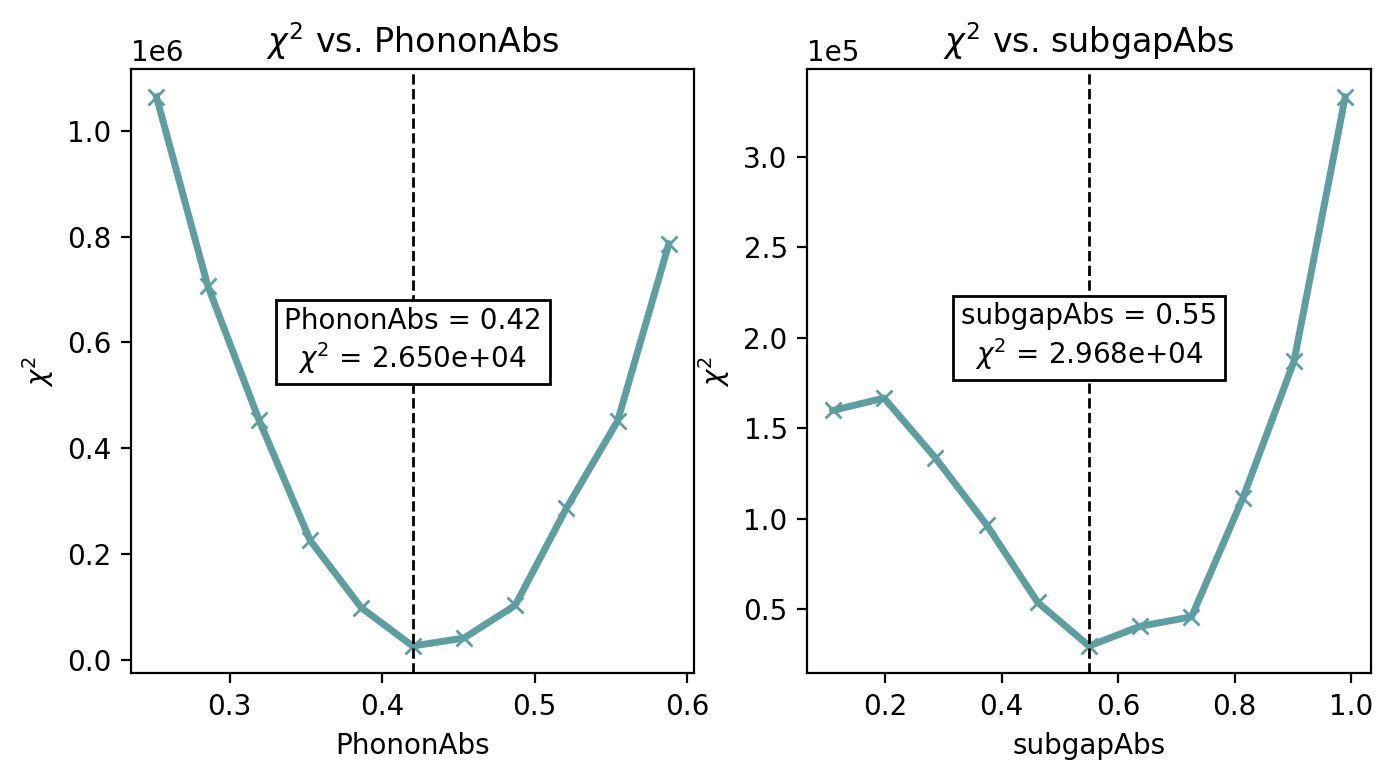

In [12]:
# This code assumes a file structure with 'chisquare' as the top level directory.
# This should contain directories 'top', 'sub', 'gap'
# in each of those directories, there should contain root files with the results of scanning
# that parameter with the parameter range defined.

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi = 200)
props = dict(boxstyle='square', facecolor='white', alpha=1)
for plot in range(2):
    files = {}
    for i in [TopRange, SubRange][plot]:
        files.update({i: f'/scratch/user/perry5334/notebooks/CDMSlite_TESCrystalSimParams/samples/chisquare/' + 
                         ['top', 'sub'][plot] + '/' + 
                         ['top', 'sub'][plot] + str(np.round(i, 5)) + '_51220719_0000.root'})
            
    d = {}
    for i in [TopRange, SubRange][plot]:
        d.update({i: {}})
                
    for i in [TopRange, SubRange][plot]:
        d[i]['tesa'], d[i]['tesb'], d[i]['tesc'], d[i]['tesd'] = getTES(files[i])
        d[i]['tes'] = sum([d[i]['tesa'], d[i]['tesb'], d[i]['tesc'], d[i]['tesd']], axis = 0)
        d[i]['chi2'], _ = ChiTemplate_full(d[i]['tes'])
        
    # after the chi2 is calculated for a parameter, its chi2 trend is plotted in a subplot.
    
    x = [TopRange, SubRange][plot]
    y = array([d[i]['chi2'] for i in x])
    currentAxis = axes.flatten()[plot]
    currentAxis.plot(x, y, 'x', ls = '-', lw = 2.5, color = 'cadetblue')
    currentAxis.set_title(r'$\chi^2$ vs. ' + ['PhononAbs', 'subgapAbs'][plot])
    currentAxis.set_xlabel(['PhononAbs', 'subgapAbs'][plot])
    currentAxis.set_ylabel(r'$\chi^2$')
    currentAxis.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    currentAxis.axvline([0.42, 0.55][plot], 0, 1, lw = 1 , ls = '--', color = 'black')
    currentAxis.text([0.42, 0.55][plot], [0.6e6, 2e5][plot],  
                     [f'PhononAbs = 0.42' + '\n' + r'$\chi^2$ = ' + f'{d[[0.42, 0.55][plot]]["chi2"]:.3e}',
                      f'subgapAbs = 0.55' + '\n' + r'$\chi^2$ = ' + f'{d[[0.42, 0.55][plot]]["chi2"]:.3e}'][plot], 
                     ha = 'center', va = 'center', bbox = props, fontsize = 10)

## Chi-square Optimization for TESSim Parameters (Full Pulse)

In [136]:
# Range of TESSim parameter values for chi2 scan
# These will probably change as you close in on a minimum

TcRange = np.round((np.linspace(0.9, 1.1, 11) * 111), 5)
TwRange = np.round((np.linspace(0.6, 1.4, 11) * 3), 5)
TsubstRange = np.round((np.linspace(0.95, 1.05, 11) * 67.25), 5)
WgammaRange = np.round((np.linspace(0.6, 1.4, 11) * 100), 5)
LRange = np.round((np.linspace(0, 1.8, 11) * 100), 5)

In [140]:
print(TcRange)

[ 99.9  102.12 104.34 106.56 108.78 111.   113.22 115.44 117.66 119.88
 122.1 ]


OSError: unable to access tree 'G4SimDir/g4dmcTES' in /scratch/user/perry5334/notebooks/CDMSlite_TESCrystalSimParams/samples/chisquare/Tsubst/Tsubst63.8875_10220719_0000.root

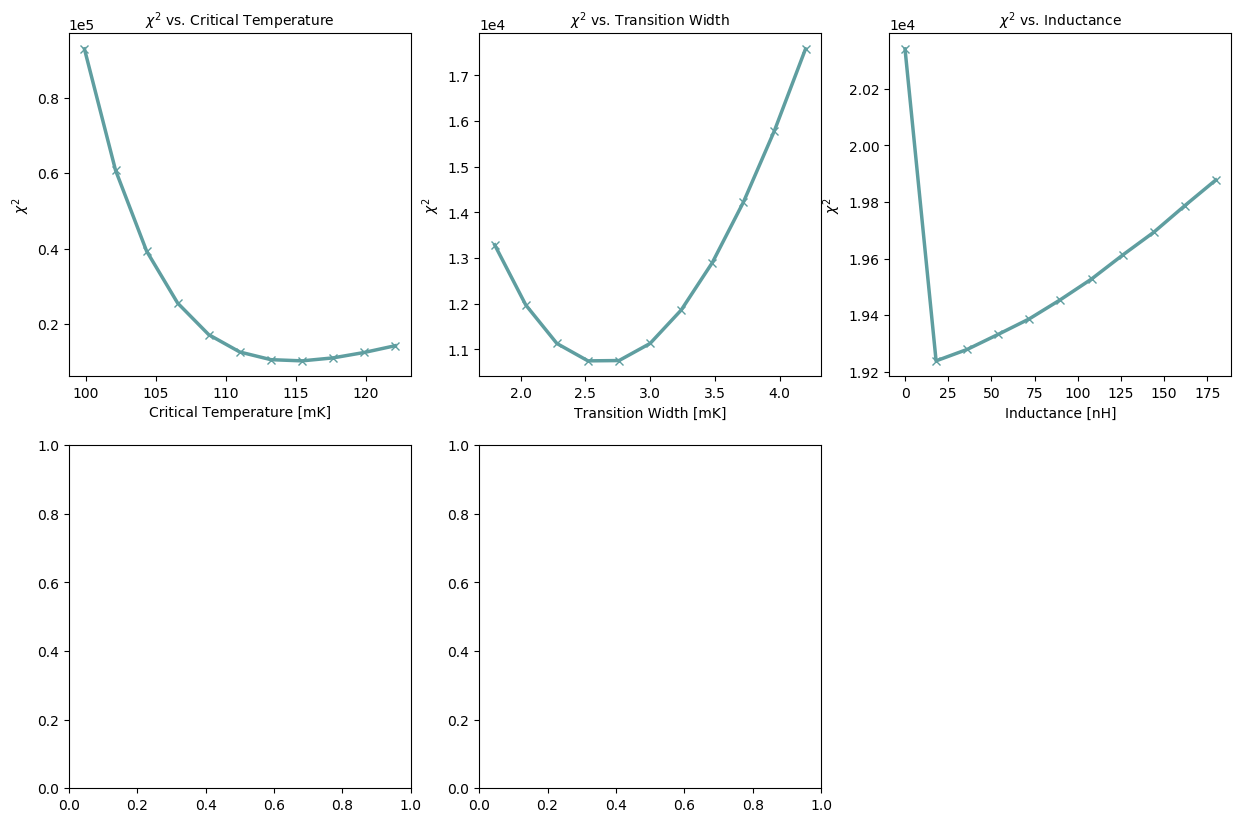

Error in <TFile::TFile>: file /scratch/user/perry5334/notebooks/CDMSlite_TESCrystalSimParams/samples/chisquare/Tsubst/Tsubst63.8875_10220719_0000.root does not exist


In [141]:
# This code assumes a file structure with 'chisquare' as the top level directory.
# This should contain directories 'Tc', 'Tw', 'L', 'Tsubst', 'Wgamma'
# in each of those directories, there should contain root files with the results of scanning
# that parameter with the parameter range defined.

fig, axes = plt.subplots(2, 3, figsize=(15 * 1, 10 * 1), dpi = 100)
fig.delaxes(axes[1,2])
for plot in range(5):
    files = {}
    for i in [TcRange, TwRange, LRange, TsubstRange, WgammaRange][plot]:
        files.update({i: f'/scratch/user/perry5334/notebooks/CDMSlite_TESCrystalSimParams/samples/chisquare/' + 
                         ['Tc', 'Tw', 'L', 'Tsubst', 'Wgamma'][plot] + '/' + 
                         ['Tc', 'Tw', 'L', 'Tsubst', 'Wgamma'][plot] + str(np.round(i, 5)) +
                          '_10220719_0000.root'})
    
    d = {}
    for i in [TcRange, TwRange, LRange, TsubstRange, WgammaRange][plot]:
        d.update({i: {}})
                
    for i in [TcRange, TwRange, LRange, TsubstRange, WgammaRange][plot]:
        d[i]['tesa'], d[i]['tesb'], d[i]['tesc'], d[i]['tesd'] = getTES(files[i])
        d[i]['tes'] = sum([d[i]['tesa'], d[i]['tesb'], d[i]['tesc'], d[i]['tesd']], axis = 0)
        d[i]['chi2'], _ = ChiTemplate_full(d[i]['tes'])
        
    # after the chi2 is calculated for a parameter, its chi2 trend is plotted in a subplot.
    
    x = [TcRange, TwRange, LRange, TsubstRange, WgammaRange][plot]
    y = array([d[i]['chi2'] for i in x])
    currentAxis = axes.flatten()[plot]
    currentAxis.plot(x, y, 'x', ls = '-', lw = 2.5, color = 'cadetblue')
    currentAxis.set_title(r'$\chi^2$ vs. ' + ['Critical Temperature', 'Transition Width', 'Inductance', 
                           'Substrate Temperature', 'Volumetric Heat Capacity Coeff.'][plot], fontsize = 10)
    currentAxis.set_xlabel(['Critical Temperature [mK]', 'Transition Width [mK]', 'Inductance [nH]', 
                           'Substrate Temperature [mK]', r'Volumetric Heat Capacity Coefficient $\frac{J}{m^3K^2}$'][plot])
    currentAxis.set_ylabel(r'$\chi^2$')
    currentAxis.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# CrystalSim Optimization Re-Check (Full Pulse)

In [ ]:
# Range of CrystalSimSim parameter values for chi2 scan

SubRange = np.round((np.linspace(0.6, 1.4, 11) * 0.0365), 5)
TopRange = np.round((np.linspace(0.6, 1.4, 11) * 0.54), 5)
GapRange = np.round((np.linspace(0.7, 1.3, 11) * 1075), 5)

In [ ]:
# This code assumes a file structure with 'chisquare' as the top level directory.
# This should contain directories 'top', 'sub', 'gap'
# in each of those directories, there should contain root files with the results of scanning
# that parameter with the parameter range defined.

fig, axes = plt.subplots(1, 3, figsize=(16, 4), dpi = 200)
for plot in range(3):
    files = {}
    for i in [TopRange, SubRange, GapRange][plot]:
        files.update({i: f'/scratch/user/perry5334/notebooks/HVeV_CrystalSimParams/samples/chisquare/' + 
                         ['top', 'sub', 'gap'][plot] + '/' + 
                         ['top', 'sub', 'gap'][plot] + str(np.round(i, 5)) + '_51220621_0000.root'})
            
    d = {}
    for i in [TopRange, SubRange, GapRange][plot]:
        d.update({i: {}})
                
    for i in [TopRange, SubRange, GapRange][plot]:
        d[i]['PhononE'] = getCrystalsim(files[i], ['PhononE'])[0]
        d[i]['PhononE1'] = np.array([j[0] for j in d[i]['PhononE']])
        d[i]['PhononE2'] = np.array([j[1] for j in d[i]['PhononE']])
        d[i]['PhononE'] = np.array([sum(j) for j in d[i]['PhononE']])
        d[i]['tes1'] = getTES(files[i])
        d[i]['chi1'] = ChiTemplate_full(d[i]['tes1'], d[i]['PhononE1'])
        
    # after the chi2 is calculated for a parameter, its chi2 trend is plotted in a subplot.
    
    x = [TopRange, SubRange, GapRange][plot]
    y = array([d[i]['chi1'] for i in x])
    currentAxis = axes.flatten()[plot]
    currentAxis.plot(x, y, 'x', ls = '-', lw = 2.5, color = 'cadetblue')
    currentAxis.set_title(r'$\chi^2$ vs. ' + ['PhononAbsTop', 'TESsubgapAbsorption', 'Energy Gap'][plot])
    currentAxis.set_xlabel(['PhononAbsTop', 'TESsubgapAbsorption', r'Energy Gap [$\mu$eV]'][plot])
    currentAxis.set_ylabel(r'$\chi^2$')
    currentAxis.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

## Visual Comparison of Optimized Pulse to Template

In [11]:
def f(tes):
    f, a = [], []
    for event in range(len(tes)):
        p1, p2 = numpy.polyfit(phononBins[825:1762], log(tes[event][825:1762]), 1)
        f.append(abs(1/p1))
        a.append(np.exp(p2))
        
    f, a = array(f), array(a)
    
    return f, a

Text(0.5, 1.0, 'Optimized Slow Trace Relative Difference to Template')

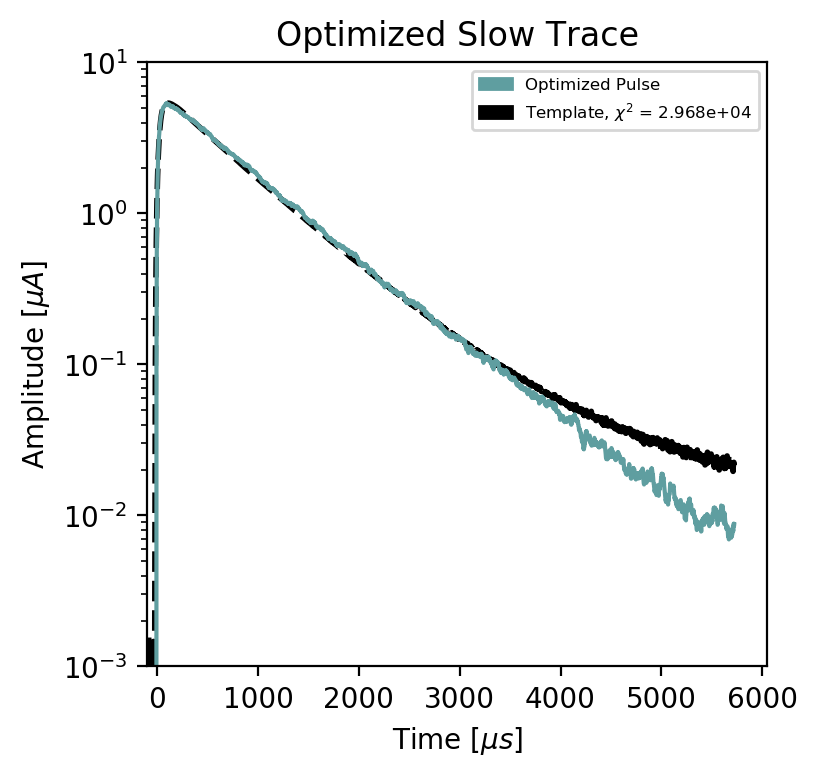

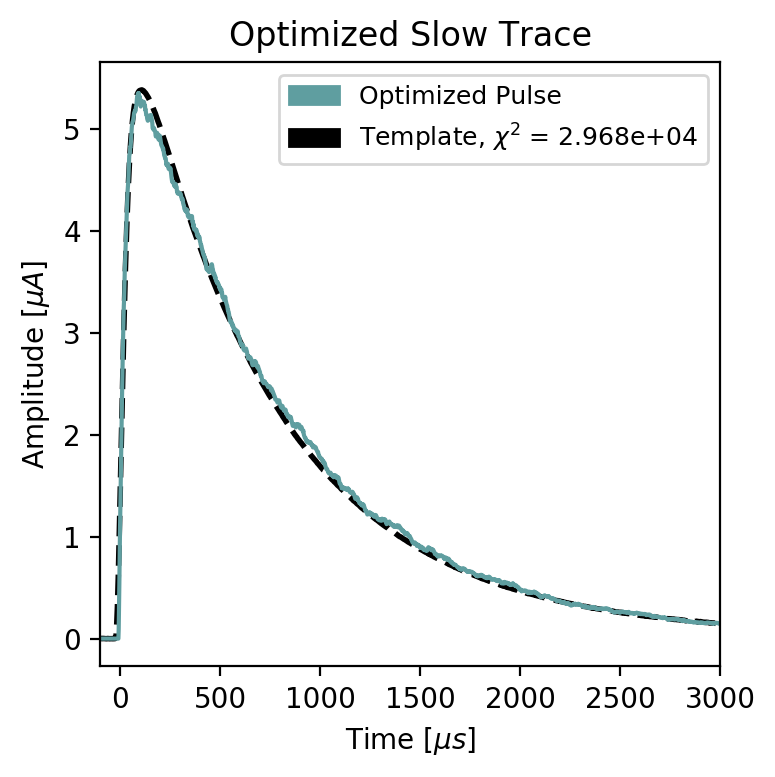

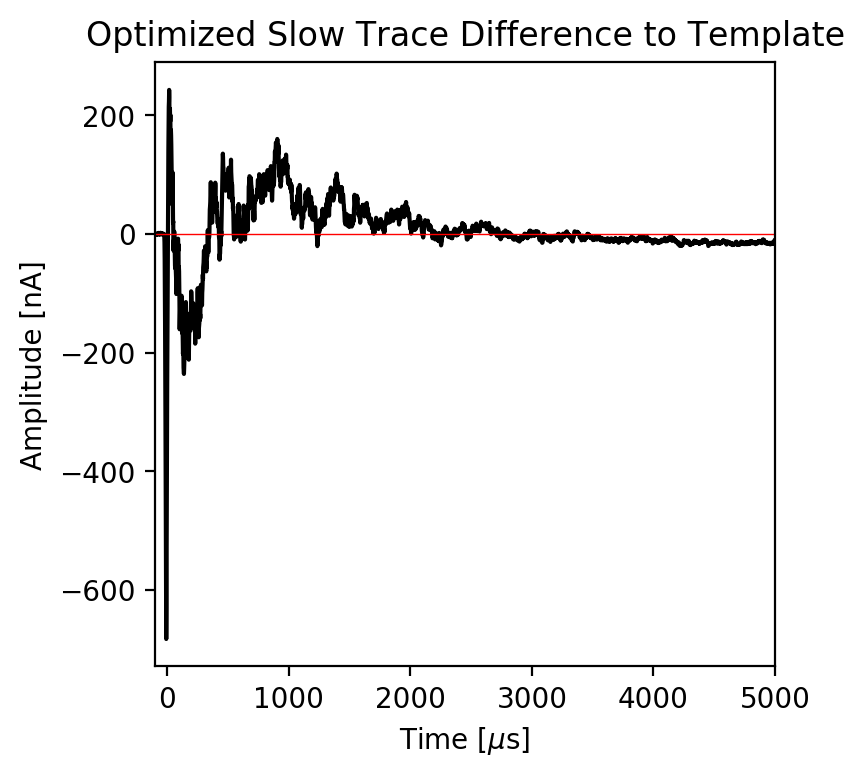

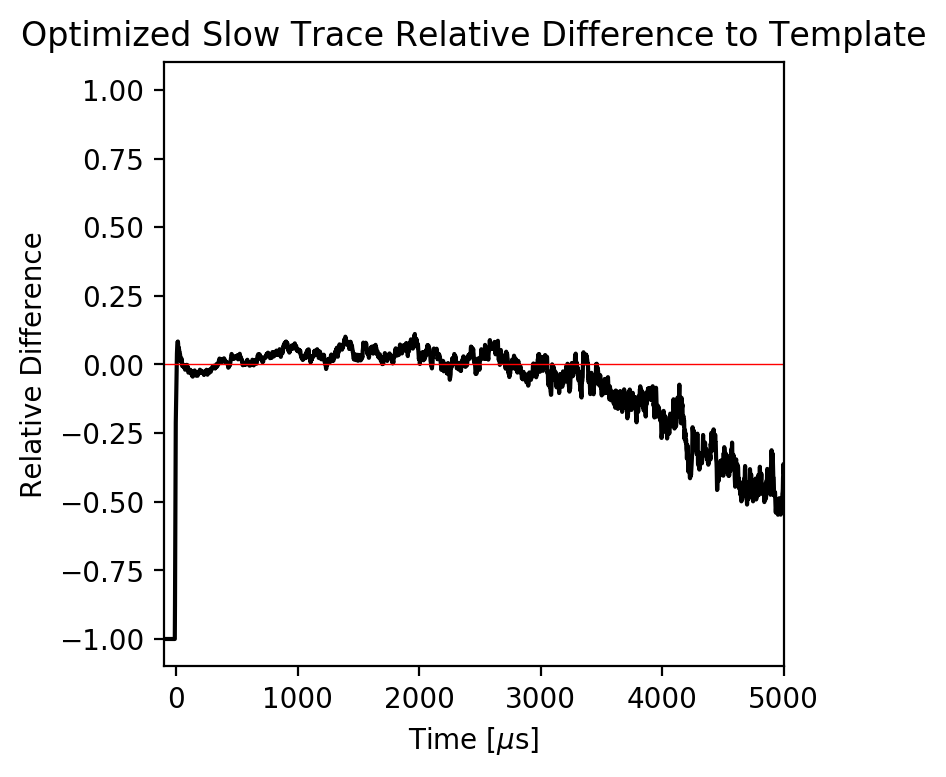

In [12]:
# after finding a parameter combination the completely minimizes the chi2 for all parameters,
# set 'file' to the file path of the sample that is run with those parameters
# the following code will plot the channel 1 pulse and the template scaled to its peak height.
# it will also make an exponential fit to two time regions and return the amplitude and fall-time

binshift = int(shift / 1.6e-6) # convert optimal time-shift from OF to a shift in bins.

file = '/scratch/user/perry5334/notebooks/CDMSlite_TESCrystalSimParams/samples/chisquare/sub/sub0.55_51220719_0000.root' # sample to use for comparison
tesa, tesb, tesc, tesd = getTES(file)
tes = sum([tesa, tesb, tesc, tesd], axis = 0)
chi2, A_hat = ChiTemplate_full(tes)
ft, a = f(tes)

cmap = plt.get_cmap('inferno')
c = [cmap(i) for i in np.linspace(0.2, 1, 5)]


#### Logscale plot of Optimized Pulse and Template #### ------------------------------------------------------------------------

plt.figure(figsize(4, 4), dpi = 200)
plt.plot(phononBins[:-binshift], template[:-binshift] * A_hat, color = 'black', lw = 2, ls = '--')
plt.plot(phononBins[:-binshift], tes[0][binshift:], color = 'cadetblue')
TES = mpatches.Patch(color='cadetblue', label='Optimized Pulse')
Template = mpatches.Patch(color='black', label= r'Template, $\chi^2$ = ' + f"{chi2:.3e}")

plt.xlim(-100, None)
plt.legend(handles=[TES, Template], fontsize = 6)
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel(r'Amplitude [$\mu A$]')
plt.title('Optimized Slow Trace')
plt.yscale('log')
plt.ylim(1e-3, 1e1)

#### Linear Scale Plot of Optimized Pulse and Template #### --------------------------------------------------------------------

plt.figure(figsize(4, 4), dpi = 200)
plt.plot(phononBins[:-binshift], template[:-binshift] * A_hat, color = 'black', lw = 2, ls = '--')
plt.plot(phononBins[:-binshift], tes[0][binshift:], color = 'cadetblue')

TES = mpatches.Patch(color='cadetblue', label='Optimized Pulse')
Template = mpatches.Patch(color='black', label= r'Template, $\chi^2$ = ' + f"{chi2:.3e}")

plt.xlim(-100, 3000)
plt.legend(loc = 'upper right', handles=[TES, Template], fontsize = 9)
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel(r'Amplitude [$\mu A$]')
plt.title('Optimized Slow Trace')

#### Plot of Difference Between Optimized Pulse and Template #### --------------------------------------------------------------

plt.figure(figsize(4, 4), dpi = 200)
plt.plot(phononBins[:-binshift], (tes[0][binshift:] - template[:-binshift] * A_hat) * 1e3, color = 'black')
plt.axhline(0, 0, 1, lw = 0.5, color = 'red')
plt.xlim(-100, 5000)
plt.xlabel(r'Time [$\mu$s]')
plt.ylabel(r'Amplitude [nA]')
plt.title('Optimized Slow Trace Difference to Template')

#### Plot of Relative Difference Between Optimized Pulse and Template #### -----------------------------------------------------

plt.figure(figsize(4, 4), dpi = 200)
plt.plot(phononBins[:-binshift], (tes[0][binshift:] - template[:-binshift] * A_hat) / (template[:-binshift] * A_hat), color = 'black')
plt.axhline(0, 0, 1, lw = 0.5, color = 'red')
plt.xlim(-100, 5000)
plt.ylim(-1.1, 1.1)
plt.xlabel(r'Time [$\mu$s]')
plt.ylabel(r'Relative Difference')
plt.title('Optimized Slow Trace Relative Difference to Template')